In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Automatically detect GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Configuration
DATASET_NAME = 'CIFAR10'
LEARNING_RATE = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 30
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9

In [ ]:
# 1. Define Transforms (Augmentation for train, Normalization for both)

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(), #  This converts the image from a PIL Image or NumPy array into a PyTorch Tensor. It also scales the pixel intensity values from the range [0, 255] to [0.0, 1.0].
    transforms.Normalize(*stats) # This normalizes the tensor images. It subtracts the mean (0.5 for each channel) and divides by the standard deviation (0.5 for each channel).
])

"""
Similar to train_transform, but for the test data.
It only includes transforms.ToTensor() and transforms.Normalize(*stats).
Crucially, data augmentation techniques (like random flips or crops) are not applied to the test set.
The test set should reflect the real-world data as accurately as possible, without artificial alterations, to get an unbiased evaluation of the model's performance.
"""
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# 2. Download and Load Data
print(f"Loading {DATASET_NAME}...")
train_data = torchvision.datasets.CIFAR10(root='./data',
                                          train=True, # Indicates that we want the training subset of the CIFAR-10 dataset.
                                          download=True,
                                          transform=train_transform # Applies the train_transform (defined in the previous cell) to each image as it's loaded. This includes augmentation (random flips, crops) and normalization.
                                          )
test_data = torchvision.datasets.CIFAR10(root='./data',
                                         train=False, # Specifies that this is the test subset.
                                         download=True,
                                         transform=test_transform) #  Applies the test_transform (which typically includes only ToTensor and Normalize without augmentation) to the test images.
# Classes in CIFAR10 dataset
num_classes = 10

train_loader = torch.utils.data.DataLoader(train_data, # The dataset object to load data from.
                                           batch_size=BATCH_SIZE, # The model will process 64 images at a time.
                                           shuffle=True, # The data will be randomly reordered at each epoch (pass through the entire dataset) to prevent the model from learning the order of samples.
                                           num_workers=2 # Uses 2 subprocesses to load data. This can speed up data loading by performing it in parallel with model training.
                                           )
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE*2, # The batch size for testing is often larger than for training (here, 128) because there's no backpropagation, so memory usage is less constrained, and larger batches can be faster for evaluation.
                                          shuffle=False, # The test data should not be shuffled. We want to evaluate the model consistently on the same order of test samples to ensure reproducibility and fair comparison.
                                          num_workers=2)

print(f"Data Loaded. Classes: {num_classes}")

Loading CIFAR10...
Data Loaded. Classes: 10


In [ ]:
class SimpleCNN(nn.Module):
    # Constructor of the model
    def __init__(self, num_classes):
        # Calls the constructor of the parent class nn.Module, which is essential for all PyTorch models.
        super(SimpleCNN, self).__init__()

        # Convolution Blocks

        # Block 1: 3->64 Channels. Captures low-level features (edges, colors).
        # This is the first convolutional layer.
        # It takes 3 input channels (for RGB images), outputs 64 feature maps, uses a 3x3 kernel (filter)
        # padding=1 ensures the output spatial dimensions remain the same as the input before pooling (e.g., a 32x32 input stays 32x32).
        # Conv2d and nn.Linear layers use He Uniform initialization by default.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64) # Batch Normalization layer applied after the first convolution. It normalizes the outputs of the convolutional layer to stabilize and accelerate training.
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2) # Output: 16x16

        # Block 2: 64->128 Channels. Captures mid-level features (textures, shapes).
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2) # Output: 8x8


        # Block 3: 128->256 Channels. Captures high-level complex features (objects, parts).
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2) # Output: 4x4

        # Fully Connected Layers
        # Final classification layer mapping the 256 pooled features directly to the 10 output classes.
        # Global Average Pooling & Classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    # This method describes how an input x (an image) passes through the layers defined in __init__.
    def forward(self, x):
        # Convolutional features
        # The input x first goes through conv1, then bn1 (batch normalization), then F.relu (Rectified Linear Unit, a common activation function), and finally self.pool (max pooling). This sequence applies to each convolutional block.

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))


        # Flatten
        # Global Average Pooling (GAP)
        # Instead of flattening a 4x4 spatial grid (which creates huge parameter counts), we average each of the 256 feature maps into a single number (1x1).
        # This reduces parameters and makes the model robust to object position.
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1) # Flatten

        # Classification
        # Finally, the features go through the second fully connected layer (fc2) to produce the final class scores.
        x = self.fc(x)
        return x

# Instantiate Model
# An instance of the SimpleCNN model is created, passing the num_classes (which is 10 for CIFAR-10).
# This moves the entire model to the specified DEVICE (either 'cuda' for GPU or 'cpu'). This is crucial for utilizing GPU acceleration if available).
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
print("Model initialized.")

Model initialized.


In [ ]:
# Helper Function
# Defines the logic for "How to train" and "How to evaluate".

# This line initializes the CrossEntropyLoss function, which is commonly used for multi-class classification problems.
# It combines nn.LogSoftmax() and nn.NLLLoss() (Negative Log Likelihood Loss) in one single class.
# Its purpose is to quantify the difference between the predicted output of the model (logits) and the true labels.
# The goal during training is to minimize this loss.
criterion = nn.CrossEntropyLoss()

# Initializes Stochastic Gradient Descent (SGD) with Nesterov Momentum.
# While Adam learns faster initially, SGD often finds better final minima for image classification.
# weight_decay=5e-4 adds L2 Regularization to prevent overfitting.
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Cosine Annealing Scheduler.
# Instead of stepping down abruptly, this smoothly decreases the learning rate
# following a cosine curve, helping the model settle into the optimal solution.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# This function encapsulates the logic for running a single training epoch (one full pass over the entire training dataset).
def train_one_epoch():

# Sets the model to training mode. This is important because certain layers, like Dropout and BatchNorm, behave differently during training (e.g., Dropout is active, BatchNorm updates statistics) than during evaluation.
    model.train()

# Initializes a variable to accumulate the loss over the current epoch.
    running_loss = 0.0

# This loop iterates through the train_loader, which provides batches of training data.
# In each iteration, inputs will be a batch of images and labels will be the corresponding true class labels.
    for inputs, labels in train_loader:
# Moves the input data and labels to the specified device (GPU if available, otherwise CPU).
# This is essential for utilizing GPU acceleration.
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
# Clears the gradients of all optimized Tensors.
# In PyTorch, gradients accumulate by default, so you need to zero them out before computing new gradients for the current batch, otherwise, you would be accumulating gradients from previous batches.
        optimizer.zero_grad()
# Performs a forward pass: the input images are fed into the model, and the model produces its predictions (outputs)
        outputs = model(inputs)
# Calculates the loss based on the model's predictions (outputs) and the true labels.
# The criterion (CrossEntropyLoss) quantifies how far off the predictions are.
        loss = criterion(outputs, labels)

# Performs a backward pass: this computes the gradients of the loss with respect to all trainable parameters in the model.
# These gradients indicate how much each parameter contributed to the loss.
        loss.backward()
# Updates the model's parameters using the computed gradients and the chosen optimization algorithm (SGD with Nesterov Momentum).
# This is where the model learns and adjusts its weights to reduce the loss.
        optimizer.step()
# Adds the loss of the current batch to running_loss.
# .item() extracts the Python number from a single-element tensor.
        running_loss += loss.item()
# After processing all batches in the epoch, it returns the average loss per batch for that epoch.
# This gives an overall measure of how well the model performed during the epoch.
    return running_loss / len(train_loader)

# This code snippet defines the evaluate() function, which is responsible for assessing the performance of your trained deep learning model on a separate test or validation dataset.
# It calculates the accuracy of the model, which is a common metric for classification tasks.
def evaluate():

# Sets the model to evaluation mode.
# This is crucial because certain layers like Dropout and BatchNorm behave differently during evaluation than during training.
# Dropout layers: Are turned off (inactive) during evaluation, meaning all neurons are used.
# BatchNorm layers: Stop updating their running statistics (mean and variance) and instead use the statistics learned during training.
# This ensures consistent predictions.
    model.eval()

# These variables are initialized to keep track of the number of correctly predicted samples and the total number of samples, respectively.
    correct = 0
    total = 0
# This is a context manager that disables gradient calculation.
# During evaluation, we don't need to compute gradients because we are not performing backpropagation to update model weights.
# Disabling gradient calculation reduces memory consumption and speeds up computations.
    with torch.no_grad():
# This loop iterates through the test_loader, which provides batches of test data (images and their corresponding true labels).
        for inputs, labels in test_loader:
# Moves the input data and labels to the specified device (GPU if available, otherwise CPU) for consistent processing with the model.
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
# Performs a forward pass: the test images (inputs) are fed into the model, and the model generates its predictions (raw scores or logits) for each class.
            outputs = model(inputs)
# outputs.data: Accesses the underlying data tensor of the outputs without tracking its history (which is already handled by torch.no_grad()).
# torch.max(..., 1): This function returns the maximum value and its index along a specified dimension (dimension 1, which corresponds to the class scores).
# The _ (underscore) is used to ignore the actual maximum values, as we are only interested in the index of the maximum score, which represents the predicted class.
            _, predicted = torch.max(outputs.data, 1)
# labels.size(0) gives the number of samples in the current batch.
# This is added to total to keep count of all samples evaluated.
            total += labels.size(0)
# (predicted == labels): This creates a boolean tensor where True indicates a correct prediction and False indicates an incorrect one.
# .sum(): Sums the True values (which are treated as 1) in the boolean tensor, giving the count of correct predictions in the current batch.
# .item(): Extracts the Python number from the single-element tensor result.
# This count is added to the correct variable.
            correct += (predicted == labels).sum().item()
# After iterating through all test batches, this line calculates the overall accuracy as a percentage ((correct predictions / total samples) * 100) and returns it.
    return 100 * correct / total

In [ ]:
# Main Execution Loop

print(f"Starting training on {DATASET_NAME}...")

# 1. Initialize lists to store metrics
train_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Train & Validate
    epoch_loss = train_one_epoch()
    scheduler.step() # New - Update LR at the end of the epoch
    epoch_acc = evaluate()

    # 2. Store metrics
    train_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

print("Training Complete.")

Starting training on CIFAR10...
Epoch [1/30] | Loss: 1.5965 | Acc: 40.45%
Epoch [2/30] | Loss: 1.0059 | Acc: 66.19%
Epoch [3/30] | Loss: 0.8030 | Acc: 68.76%
Epoch [4/30] | Loss: 0.7064 | Acc: 60.18%
Epoch [5/30] | Loss: 0.6453 | Acc: 58.37%
Epoch [6/30] | Loss: 0.6093 | Acc: 76.75%
Epoch [7/30] | Loss: 0.5842 | Acc: 70.84%
Epoch [8/30] | Loss: 0.5491 | Acc: 76.24%
Epoch [9/30] | Loss: 0.5331 | Acc: 77.52%
Epoch [10/30] | Loss: 0.5172 | Acc: 69.41%
Epoch [11/30] | Loss: 0.4947 | Acc: 78.75%
Epoch [12/30] | Loss: 0.4776 | Acc: 80.48%
Epoch [13/30] | Loss: 0.4632 | Acc: 82.12%
Epoch [14/30] | Loss: 0.4345 | Acc: 78.76%
Epoch [15/30] | Loss: 0.4227 | Acc: 81.78%
Epoch [16/30] | Loss: 0.4035 | Acc: 82.41%
Epoch [17/30] | Loss: 0.3792 | Acc: 81.04%
Epoch [18/30] | Loss: 0.3620 | Acc: 79.42%
Epoch [19/30] | Loss: 0.3359 | Acc: 84.23%
Epoch [20/30] | Loss: 0.3143 | Acc: 84.82%
Epoch [21/30] | Loss: 0.2902 | Acc: 86.42%
Epoch [22/30] | Loss: 0.2579 | Acc: 88.19%
Epoch [23/30] | Loss: 0.2319 | 

In [ ]:
from sklearn.metrics import classification_report

def get_all_predictions(loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Move to CPU and convert to numpy for sklearn
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions
print("Running evaluation on full test set...")
y_pred, y_true = get_all_predictions(test_loader, model)

# Print a text-based report
print(classification_report(y_true, y_pred, digits=3))

Running evaluation on full test set...
              precision    recall  f1-score   support

           0      0.913     0.946     0.929      1000
           1      0.966     0.966     0.966      1000
           2      0.913     0.890     0.901      1000
           3      0.853     0.839     0.846      1000
           4      0.912     0.944     0.928      1000
           5      0.886     0.890     0.888      1000
           6      0.947     0.939     0.943      1000
           7      0.973     0.940     0.956      1000
           8      0.957     0.954     0.955      1000
           9      0.940     0.949     0.944      1000

    accuracy                          0.926     10000
   macro avg      0.926     0.926     0.926     10000
weighted avg      0.926     0.926     0.926     10000



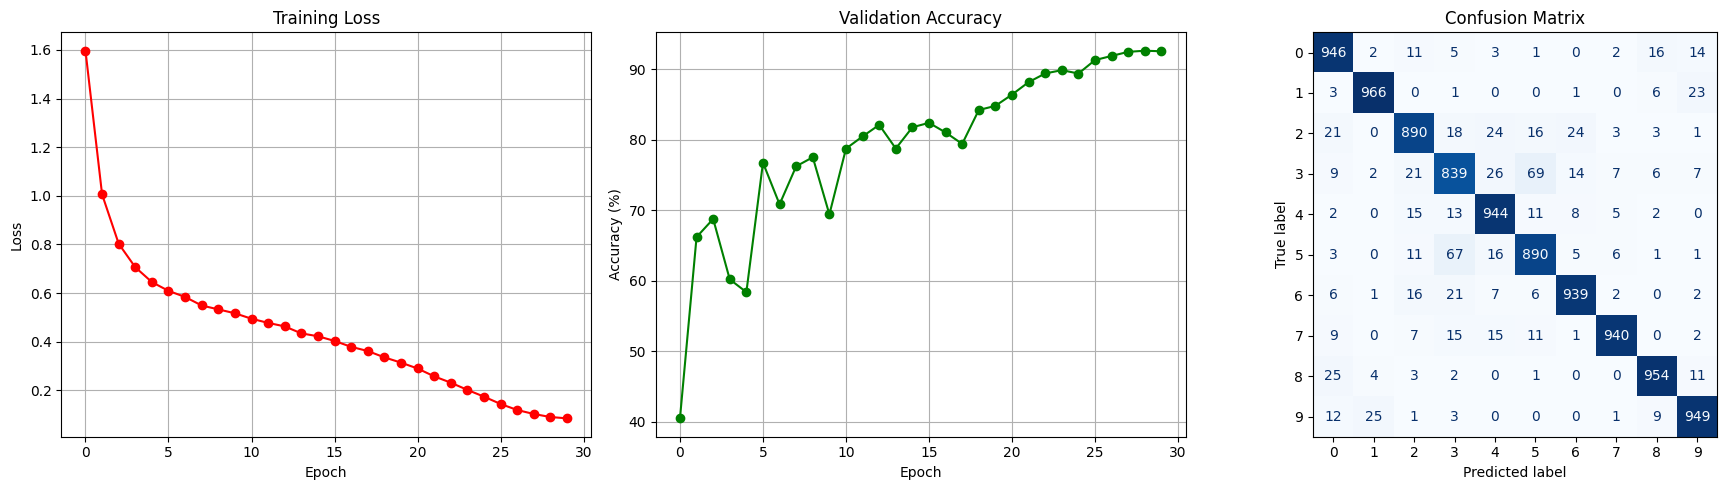

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss Curve
ax1.plot(train_losses, marker='o', color='red', label='Training Loss')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# 2. Accuracy Curve
ax2.plot(val_accuracies, marker='o', color='green', label='Validation Accuracy')
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True)

# 3. Confusion Matrix
# Calculate the matrix
cm = confusion_matrix(y_true, y_pred)
# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap='Blues', ax=ax3, colorbar=False)
ax3.set_title("Confusion Matrix")

plt.tight_layout()
plt.show()